# Artificial Neural Networks with TensorFlow.Keras

In this notebook we will see how to use TensorFlow to train ANNs and avoid needing to extract features like we did in the previous notebook.

Let's grab the same digit data we used before!

In [76]:
! git clone https://github.com/Jakobovski/free-spoken-digit-dataset.git

Cloning into 'free-spoken-digit-dataset'...
remote: Counting objects: 2089, done.
remote: Total 2089 (delta 0), reused 0 (delta 0), pack-reused 2089
Receiving objects: 100% (2089/2089), 20.90 MiB | 35.26 MiB/s, done.
Resolving deltas: 100% (39/39), done.


In [0]:
import os
os.chdir('free-spoken-digit-dataset/recordings')

In [78]:
import glob, os

wavfiles = list()
for file in glob.glob("*.wav"):
    wavfiles.append(file)

num_points = len(wavfiles)

print('{} data points\n'.format(num_points))

# list the first few files
wavfiles[:10]



1500 data points



['0_theo_16.wav',
 '9_jackson_26.wav',
 '3_jackson_28.wav',
 '1_theo_22.wav',
 '6_jackson_34.wav',
 '4_jackson_20.wav',
 '9_jackson_47.wav',
 '1_theo_29.wav',
 '3_jackson_21.wav',
 '6_jackson_6.wav']

In [0]:

import numpy as np
import scipy.io.wavfile
from IPython.display import Audio
import matplotlib.pyplot as plt
import matplotlib
import tensorflow as tf
from sklearn import metrics
import pandas as pd

%matplotlib inline
matplotlib.rcParams.update({'font.size': 16,'figure.figsize':(10,6)})


## Load the data

In [0]:
import re

re_digit = re.compile('\d+_')
re_speaker = re.compile('_[a-z]+_')
re_trial = re.compile('_\d+.')

X_data = np.ndarray(shape=(num_points,),dtype=object)
y_labels = list()

label='digit'

In [81]:
ix = 0
for sample_file in wavfiles:
  try:
    
    digit = int(re.match( re_digit, sample_file)[0][:-1])
    speaker = re.search( re_speaker, sample_file)[0][1:-1]

    # read the file
    (sample_rate, signal) = scipy.io.wavfile.read(sample_file)
    
    # some files have two channels... just take the first one
    if len(signal.shape) == 2:
      signal = signal[:,0]
      
    
    X_data[ix,] = np.array(signal)
    
    ix+=1
    
    if label == 'speaker':
      y_labels.append(speaker)
      
    elif label == 'digit':
      y_labels.append(digit)
      
    else:
      print("I don't know what you want to predict...")
      break
      
    
  except Exception as e:
    
    # something went wrong!  =(
    
    print(sample_file)
    print(e)
    print(X_data.shape)
    print(signal.shape)
    
    break


/usr/local/lib/python3.6/dist-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


## Normalize the inputs
Each .wav file is a different duration.  If we want to use the raw input as the signals, this will make our neural net cranky.  Let's artifically pad or truncate our input vectors so they're all the same length.  (Warning: we may lose data!)

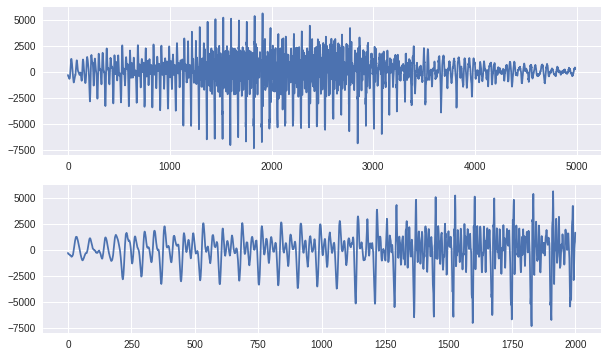

In [82]:
# Remove the mean from the data
# For each data point:
#   1) Remove the mean
#   2) Make the length = 2000
s_plot_ix = 1
desired_length = 2000
plt.subplot(2,1,1)
plt.plot(X_data[s_plot_ix])

for ix in range(X_data.shape[0]):
  len_sig = X_data[ix].shape[0]
  
  if len_sig < desired_length:
    pad_len = desired_length - len_sig
    X_data[ix] = np.append(X_data[ix], np.mean(X_data[ix]) * np.ones(pad_len))
  elif len_sig > desired_length:
    X_data[ix] = X_data[ix][:desired_length]
  
  X_data[ix] = X_data[ix]-np.mean(X_data[ix])

plt.subplot(2,1,2)
plt.plot(X_data[s_plot_ix])

In [83]:
# turn y_labels into categories (0,1,2)

## YOUR CODE HERE

labels = np.array(list(set(y_labels)))
print(labels)

for j in range(len(y_labels)):
  y_labels[j]=np.where(labels==y_labels[j])[0][0]
print(set(y_labels))

[0 1 2 3 4 5 6 7 8 9]
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


## Split data into test/train split

In [0]:
from sklearn.model_selection import train_test_split

# split X and y into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_data, np.array(y_labels), test_size=0.25)

In [85]:
print(X_train.shape)
print(y_train.shape)

(1125,)
(1125,)


## Reformat the labels

Next, we want to convert the labels from an integer format (e.g., "2"), to a [one hot encoding](https://en.wikipedia.org/wiki/One-hot) (e.g., "0, 0, 1, 0, 0, 0, 0, 0, 0, 0"). To do so, we'll use the `tf.keras.utils.to_categorical` [function](https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical) function.

In [86]:
NUM_DIGITS = 10

print("Before", y_train[0])

y_train = tf.keras.utils.to_categorical(y_train, NUM_DIGITS)

print("After", y_train[0])

y_test = tf.keras.utils.to_categorical(y_train, NUM_DIGITS)

Before 3
After [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


In [0]:
# The X data is in a variable-length array, which will make TensorFlow cranky... we're going to hack something together to fix that


X_train_df = pd.DataFrame()
for xx in X_train:
  X_train_df=X_train_df.append(pd.Series(xx),ignore_index=True)


X_test_df = pd.DataFrame()
for xx in X_test:
  X_test_df=X_test_df.append(pd.Series(xx),ignore_index=True)

## Build the model

Now, we'll create our neural network using the [Keras Sequential API](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential). 
* Architecture wise, we'll single layer network. 
* The hidden layer will have 512 units using the [ReLU](https://www.tensorflow.org/api_docs/python/tf/keras/activations/relu) activation function. 
* The output layer will have 10 units and use [softmax](https://www.tensorflow.org/api_docs/python/tf/keras/activations/softmax) function. 
* Note: you will need to specify the input shape on the first layer. If you add subsequent layers, this is not necessary. 
* We will use the [categorical crossentropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/categorical_crossentropy) loss function, and the [RMSProp](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/RMSprop) optimizer.

In [88]:
# Build a fully-connected ANN with one hidden layer
from keras.layers import Dense, Activation


model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(512, activation = tf.nn.relu, input_shape=X_train[0].shape))   # hidden layer with 512 units and relu activation
model.add(tf.keras.layers.Dense(10, activation = tf.nn.softmax))   # output layer with 10 units and softmax activation
model.compile(loss = 'sparse_categorical_crossentropy',
             optimizer = 'rmsprop',
             metrics=["accuracy"])## YOUR CODE HERE)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 512)               1024512   
_________________________________________________________________
dense_3 (Dense)              (None, 10)                5130      
Total params: 1,029,642
Trainable params: 1,029,642
Non-trainable params: 0
_________________________________________________________________


## Training

Next, we will train the model by using the [fit method](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential#fit) for 10 [epochs](https://www.quora.com/What-is-epochs-in-machine-learning). We will keep track of the training loss and accuracy as we go. Please be patient as this step may take a while depending on your hardware.

Epoch 1/100
1125/1125 [==============================] - 1s 688us/step - loss: 13.2093 - acc: 0.1440
Epoch 2/100
1125/1125 [==============================] - 1s 544us/step - loss: 12.3487 - acc: 0.2222
Epoch 3/100
1125/1125 [==============================] - 1s 546us/step - loss: 12.0773 - acc: 0.2409
Epoch 4/100
1125/1125 [==============================] - 1s 529us/step - loss: 11.9728 - acc: 0.2436
Epoch 5/100
1125/1125 [==============================] - 1s 536us/step - loss: 11.5726 - acc: 0.2729
Epoch 6/100
1125/1125 [==============================] - 1s 532us/step - loss: 11.4259 - acc: 0.2827
Epoch 7/100
1125/1125 [==============================] - 1s 539us/step - loss: 11.0804 - acc: 0.3084
Epoch 8/100
1125/1125 [==============================] - 1s 528us/step - loss: 11.1818 - acc: 0.3031
Epoch 9/100
1125/1125 [==============================] - 1s 528us/step - loss: 11.1223 - acc: 0.3049
Epoch 10/100
1125/1125 [==============================] - 1s 530us/step - loss: 11.1897 - a

1125/1125 [==============================] - 1s 544us/step - loss: 10.9577 - acc: 0.3182
Epoch 14/100
1125/1125 [==============================] - 1s 530us/step - loss: 11.1030 - acc: 0.3084
Epoch 15/100
1125/1125 [==============================] - 1s 552us/step - loss: 11.0151 - acc: 0.3120
Epoch 16/100
1125/1125 [==============================] - 1s 533us/step - loss: 10.8329 - acc: 0.3253
Epoch 17/100
1125/1125 [==============================] - 1s 538us/step - loss: 10.7635 - acc: 0.3307
Epoch 18/100
1125/1125 [==============================] - 1s 542us/step - loss: 10.8325 - acc: 0.3271
Epoch 19/100
1125/1125 [==============================] - 1s 517us/step - loss: 10.8174 - acc: 0.3280
Epoch 20/100
1125/1125 [==============================] - 1s 521us/step - loss: 10.7742 - acc: 0.3298
Epoch 21/100
1125/1125 [==============================] - 1s 534us/step - loss: 10.6773 - acc: 0.3369
Epoch 22/100
1125/1125 [==============================] - 1s 548us/step - loss: 10.7873 - acc: 

1125/1125 [==============================] - 1s 553us/step - loss: 10.5591 - acc: 0.3449
Epoch 26/100
1125/1125 [==============================] - 1s 542us/step - loss: 10.5591 - acc: 0.3449
Epoch 27/100
1125/1125 [==============================] - 1s 551us/step - loss: 10.5735 - acc: 0.3440
Epoch 28/100
1125/1125 [==============================] - 1s 561us/step - loss: 10.5878 - acc: 0.3431
Epoch 29/100
1125/1125 [==============================] - 1s 551us/step - loss: 10.5878 - acc: 0.3431
Epoch 30/100
1125/1125 [==============================] - 1s 541us/step - loss: 10.6021 - acc: 0.3422
Epoch 31/100
1125/1125 [==============================] - 1s 541us/step - loss: 10.6021 - acc: 0.3422
Epoch 32/100
1125/1125 [==============================] - 1s 549us/step - loss: 10.6021 - acc: 0.3422
Epoch 33/100
1125/1125 [==============================] - 1s 548us/step - loss: 10.6021 - acc: 0.3422
Epoch 34/100
1125/1125 [==============================] - 1s 568us/step - loss: 10.6021 - acc: 

Epoch 37/100
1125/1125 [==============================] - 1s 538us/step - loss: 10.6021 - acc: 0.3422
Epoch 38/100
1125/1125 [==============================] - 1s 538us/step - loss: 10.6021 - acc: 0.3422
Epoch 39/100
1125/1125 [==============================] - 1s 547us/step - loss: 10.6021 - acc: 0.3422
Epoch 40/100
1125/1125 [==============================] - 1s 556us/step - loss: 10.6021 - acc: 0.3422
Epoch 41/100
1125/1125 [==============================] - 1s 541us/step - loss: 10.6021 - acc: 0.3422
Epoch 42/100
1125/1125 [==============================] - 1s 532us/step - loss: 10.6021 - acc: 0.3422
Epoch 43/100
1125/1125 [==============================] - 1s 523us/step - loss: 10.6021 - acc: 0.3422
Epoch 44/100
1125/1125 [==============================] - 1s 533us/step - loss: 10.6021 - acc: 0.3422
Epoch 45/100
1125/1125 [==============================] - 1s 525us/step - loss: 10.6021 - acc: 0.3422
Epoch 46/100
1125/1125 [==============================] - 1s 524us/step - loss: 10

1125/1125 [==============================] - 1s 524us/step - loss: 10.6021 - acc: 0.3422
Epoch 50/100
1125/1125 [==============================] - 1s 516us/step - loss: 10.6021 - acc: 0.3422
Epoch 51/100
1125/1125 [==============================] - 1s 521us/step - loss: 10.6021 - acc: 0.3422
Epoch 52/100
1125/1125 [==============================] - 1s 522us/step - loss: 10.6021 - acc: 0.3422
Epoch 53/100
1125/1125 [==============================] - 1s 506us/step - loss: 10.6021 - acc: 0.3422
Epoch 54/100
1125/1125 [==============================] - 1s 523us/step - loss: 10.6021 - acc: 0.3422
Epoch 55/100
1125/1125 [==============================] - 1s 525us/step - loss: 10.6021 - acc: 0.3422
Epoch 56/100
1125/1125 [==============================] - 1s 536us/step - loss: 10.6021 - acc: 0.3422
Epoch 57/100
1125/1125 [==============================] - 1s 540us/step - loss: 10.6021 - acc: 0.3422
Epoch 58/100
1125/1125 [==============================] - 1s 557us/step - loss: 10.6021 - acc: 

1125/1125 [==============================] - 1s 546us/step - loss: 10.6021 - acc: 0.3422
Epoch 62/100
1125/1125 [==============================] - 1s 544us/step - loss: 10.6021 - acc: 0.3422
Epoch 63/100
1125/1125 [==============================] - 1s 564us/step - loss: 10.6021 - acc: 0.3422
Epoch 64/100
1125/1125 [==============================] - 1s 552us/step - loss: 10.6021 - acc: 0.3422
Epoch 65/100
1125/1125 [==============================] - 1s 539us/step - loss: 10.6021 - acc: 0.3422
Epoch 66/100
1125/1125 [==============================] - 1s 537us/step - loss: 10.6021 - acc: 0.3422
Epoch 67/100
1125/1125 [==============================] - 1s 543us/step - loss: 10.6021 - acc: 0.3422
Epoch 68/100
1125/1125 [==============================] - 1s 542us/step - loss: 10.6021 - acc: 0.3422
Epoch 69/100
1125/1125 [==============================] - 1s 546us/step - loss: 10.6021 - acc: 0.3422
Epoch 70/100
1125/1125 [==============================] - 1s 540us/step - loss: 10.6021 - acc: 

1125/1125 [==============================] - 1s 537us/step - loss: 10.6021 - acc: 0.3422
Epoch 74/100
1125/1125 [==============================] - 1s 531us/step - loss: 10.6021 - acc: 0.3422
Epoch 75/100
1125/1125 [==============================] - 1s 524us/step - loss: 10.6021 - acc: 0.3422
Epoch 76/100
1125/1125 [==============================] - 1s 530us/step - loss: 10.6021 - acc: 0.3422
Epoch 77/100
1125/1125 [==============================] - 1s 531us/step - loss: 10.6021 - acc: 0.3422
Epoch 78/100
1125/1125 [==============================] - 1s 535us/step - loss: 10.6021 - acc: 0.3422
Epoch 79/100
1125/1125 [==============================] - 1s 531us/step - loss: 10.6021 - acc: 0.3422
Epoch 80/100
1125/1125 [==============================] - 1s 540us/step - loss: 10.6021 - acc: 0.3422
Epoch 81/100
1125/1125 [==============================] - 1s 526us/step - loss: 10.6021 - acc: 0.3422
Epoch 82/100
1125/1125 [==============================] - 1s 542us/step - loss: 10.6021 - acc: 

1125/1125 [==============================] - 1s 540us/step - loss: 10.6021 - acc: 0.3422
Epoch 86/100
1125/1125 [==============================] - 1s 543us/step - loss: 10.6021 - acc: 0.3422
Epoch 87/100
1125/1125 [==============================] - 1s 546us/step - loss: 10.6021 - acc: 0.3422
Epoch 88/100
1125/1125 [==============================] - 1s 545us/step - loss: 10.6021 - acc: 0.3422
Epoch 89/100
1125/1125 [==============================] - 1s 532us/step - loss: 10.6021 - acc: 0.3422
Epoch 90/100
1125/1125 [==============================] - 1s 555us/step - loss: 10.6021 - acc: 0.3422
Epoch 91/100
1125/1125 [==============================] - 1s 556us/step - loss: 10.6021 - acc: 0.3422
Epoch 92/100
1125/1125 [==============================] - 1s 564us/step - loss: 10.6021 - acc: 0.3422
Epoch 93/100
1125/1125 [==============================] - 1s 560us/step - loss: 10.6021 - acc: 0.3422
Epoch 94/100
1125/1125 [==============================] - 1s 552us/step - loss: 10.6021 - acc: 

1125/1125 [==============================] - 1s 537us/step - loss: 10.6021 - acc: 0.3422
Epoch 98/100
1125/1125 [==============================] - 1s 539us/step - loss: 10.6021 - acc: 0.3422
Epoch 99/100
1125/1125 [==============================] - 1s 548us/step - loss: 10.6021 - acc: 0.3422
Epoch 100/100
1125/1125 [==============================] - 1s 550us/step - loss: 10.6021 - acc: 0.3422


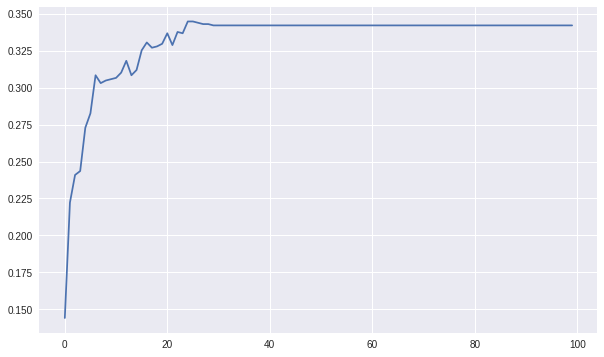

In [89]:
history = model.fit(X_train_df, y_train, epochs=100)

# plot metrics
plt.plot(history.history['acc'])
plt.show()

## Testing
Now that we have trained our model, we want to evaluate it. The training accuracy wasn't great (~35%, depending on the random seed), but better than random (10%).  Let's see how well we do on our test data.

In [90]:
loss, accuracy = model.evaluate(X_test_df, y_test)
print('Test accuracy: %.2f' % (accuracy))

ValueError: ignored

In [0]:
y_pred = model.predict_proba(X_test_df, verbose=1)

ix_pred = [np.argmax(y) for y in y_pred]
ix_true = [np.argmax(y) for y in y_test]

In [0]:
# Visualize the confusion matrix
def plot_cmatrix(cm,labels,title='Confusion Matrix'):
  fig = plt.figure()
  ax = fig.add_subplot(111)
  cax = ax.matshow(cm,cmap='Reds')
  plt.title('\n'+title+'\n', fontsize=20)
  fig.colorbar(cax)
  ax.set_xticks(range(len(labels)))
  ax.set_yticks(range(len(labels)))
  ax.set_xticklabels(labels, fontsize=16)
  ax.set_yticklabels(labels, fontsize=16)
  plt.xlabel('Predicted', fontsize=16)
  plt.ylabel('True', fontsize=16)
  plt.show()

In [0]:
cm = metrics.confusion_matrix(ix_true,ix_pred, range(10))
plot_cmatrix(cm, range(10))

### Conclusions
As you can see, this is actually a pretty terrible classifier... 
* Play around with some of the model parameters to see if you can make it better.  Later we'll see how we can use convolutions to solve a similar problem!
* Try to see if you can train a better classifier using the frequency spectrum instead of the raw signal.  You won't have to pad/truncate the data because the data should all be the same size in the frequency domain (assuming they are all sampled at the same rate, which they are)!